<a href="https://colab.research.google.com/github/benny4421/ETRI_Lifelog/blob/main/%EB%B2%A0%EC%9D%B4%EC%8A%A4_%EB%9D%BC%EC%9D%B8_%5Bpublic__0_55813%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBM

## 라이브러리 import

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import numpy as np
import pandas as pd
import glob
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from collections import Counter

In [37]:
# seed 고정
SD = 42
random.seed(SD)
np.random.seed(SD)
os.environ['PYTHONHASHSEED'] = str(SD)

## Data Processing

### 데이터 로드

In [38]:
# 파일 경로 설정
data_dir = '/content/drive/MyDrive/ETRI_lifelog_dataset/ch2025_data_items'

# Parquet 파일 전체 경로 리스트
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet'))

In [39]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리
lifelog_data = {}

# 파일별로 읽기
for file_path in parquet_files:
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '')
    lifelog_data[name] = pd.read_parquet(file_path)
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}")

✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [40]:
# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당
for key, df in lifelog_data.items():
    globals()[f"{key}_df"] = df

In [41]:
# lifelog_date가 timestamp랑 같다
metrics_train = pd.read_csv('/content/drive/MyDrive/ETRI_lifelog_dataset/ch2025_metrics_train.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/ETRI_lifelog_dataset/ch2025_submission_sample.csv')

In [42]:
# ✅ 기준 쌍 (subject_id, lifelog_date)
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date'])
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date))

# ✅ DataFrame 별 timestamp 컬럼 수동 지정
dataframes = {
    'mACStatus': (mACStatus_df, 'timestamp'),
    'mActivity': (mActivity_df, 'timestamp'),
    'mAmbience': (mAmbience_df, 'timestamp'),
    'mBle': (mBle_df, 'timestamp'),
    'mGps': (mGps_df, 'timestamp'),
    'mLight': (mLight_df, 'timestamp'),
    'mScreenStatus': (mScreenStatus_df, 'timestamp'),
    'mUsageStats': (mUsageStats_df, 'timestamp'),
    'mWifi': (mWifi_df, 'timestamp'),
    'wHr': (wHr_df, 'timestamp'),
    'wLight': (wLight_df, 'timestamp'),
    'wPedo': (wPedo_df, 'timestamp'),
}

# ✅ 분리 함수
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])
    df['date_only'] = df[timestamp_col].dt.date
    df['key'] = list(zip(df[subject_col], df['date_only']))

    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    return test_df, train_df

# ✅ 결과 저장
for name, (df, ts_col) in dataframes.items():
    print(f"⏳ {name} 분리 중...")
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col)
    globals()[f"{name}_test"] = test_df
    globals()[f"{name}_train"] = train_df
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}")

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


### 분단위 -> 하루 단위 def

In [43]:
def process_mACStatus(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_charging'].values  # 0/1 상태
        times = group['timestamp'].values

        # 충전 상태 비율
        ratio_charging = status.mean()

        # 상태 전이 횟수
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        lengths = []
        current_len = 0
        for val in status:
            if val == 1:
                current_len += 1
            elif current_len > 0:
                lengths.append(current_len)
                current_len = 0
        if current_len > 0:
            lengths.append(current_len)

        avg_charging_duration = np.mean(lengths) if lengths else 0
        max_charging_duration = np.max(lengths) if lengths else 0

        results.append({
            'subject_id': subj,
            'date': date,
            'charging_ratio': ratio_charging,
            'charging_transitions': transitions,
            'avg_charging_duration': avg_charging_duration,
            'max_charging_duration': max_charging_duration,
        })

    return pd.DataFrame(results)

mACStatus_df2 = process_mACStatus(mACStatus_df)

In [44]:
def process_mActivity(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        counts = group['m_activity'].value_counts(normalize=True)  # 비율
        row = {'subject_id': subj, 'date': date}

        # 0~8 비율 저장
        for i in range(9):
            row[f'activity_{i}_ratio'] = counts.get(i, 0)

        # 주요 활동 정보
        row['dominant_activity'] = group['m_activity'].mode()[0]
        row['num_unique_activities'] = group['m_activity'].nunique()

        summary.append(row)

    return pd.DataFrame(summary)

mActivity_df2 = process_mActivity(mActivity_df)

In [45]:
# 지정된 10개 라벨
top_10_labels = [
    "Inside, small room", "Speech", "Silence", "Music",
    "Narration, monologue", "Child speech, kid speaking",
    "Conversation", "Speech synthesizer", "Shout", "Babbling"
]

def process_mAmbience_top10(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # 초기화
    for label in top_10_labels + ['others']:
        df[label] = 0.0

    for idx, row in df.iterrows():
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience']
        others_prob = 0.0

        for label, prob in parsed:
            prob = float(prob)
            if label in top_10_labels:
                df.at[idx, label] = prob
            else:
                others_prob += prob

        df.at[idx, 'others'] = others_prob

    return df.drop(columns=['m_ambience'])

mAmbience_df2= process_mAmbience_top10(mAmbience_df)

def summarize_mAmbience_daily(df):
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']]

    # 하루 단위로 평균값 요약
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index()
    return daily_summary

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2)

In [46]:
def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0
        class_other_cnt = 0

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                if str(device['device_class']) == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'date': row['date'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):
    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 단위로 cnt 합치기
    grouped = df.groupby(['subject_id', 'date']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 총합 구해서 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 필요 없는 원래 cnt 컬럼 제거
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True)

    return grouped

mBle_df2 = summarize_mBle_daily(mBle_df)

In [47]:
def process_mGps(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps']

        altitudes = []
        latitudes = []
        longitudes = []
        speeds = []

        for entry in gps_list:
            try:
                altitudes.append(float(entry['altitude']))
                latitudes.append(float(entry['latitude']))
                longitudes.append(float(entry['longitude']))
                speeds.append(float(entry['speed']))
            except:
                continue

        features.append({
            'subject_id': row['subject_id'],
            'date': row['date'],
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan,
            'latitude_std': np.std(latitudes) if latitudes else np.nan,
            'longitude_std': np.std(longitudes) if longitudes else np.nan,
            'speed_mean': np.mean(speeds) if speeds else np.nan,
            'speed_max': np.max(speeds) if speeds else np.nan,
            'speed_std': np.std(speeds) if speeds else np.nan,
        })

    return pd.DataFrame(features)

m_Gps_df2 = process_mGps(mGps_df)

m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({
    'altitude_mean': 'mean',
    'latitude_std': 'mean',
    'longitude_std': 'mean',
    'speed_mean': 'mean',
    'speed_max': 'max',
    'speed_std': 'mean'
}).reset_index()

In [48]:
def process_mLight(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 밤(22~05시), 낮(06~21시) 구분
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6)

    # 하루 단위 요약
    daily = df.groupby(['subject_id', 'date']).agg(
        light_mean=('m_light', 'mean'),
        light_std=('m_light', 'std'),
        light_max=('m_light', 'max'),
        light_min=('m_light', 'min'),
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()),
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()),
        light_night_ratio=('is_night', 'mean')  # 밤 시간 측정 비율
    ).reset_index()

    return daily

mLight_df2 = process_mLight(mLight_df)

In [49]:
def process_mScreenStatus(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_screen_use'].values
        ratio_on = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        durations = []
        current = 0
        for val in status:
            if val == 1:
                current += 1
            elif current > 0:
                durations.append(current)
                current = 0
        if current > 0:
            durations.append(current)

        features.append({
            'subject_id': subj,
            'date': date,
            'screen_on_ratio': ratio_on,
            'screen_on_transitions': transitions,
            'screen_on_duration_avg': np.mean(durations) if durations else 0,
            'screen_on_duration_max': np.max(durations) if durations else 0,
        })

    return pd.DataFrame(features)

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df)

In [50]:
top_apps = [
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', '성경일독Q',
    'YouTube', '통화', '메시지', '타임스프레드', 'Instagram']

def process_mUsageStats(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        app_time = {app: 0 for app in top_apps}
        others_time = 0

        for row in group['m_usage_stats']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for entry in parsed:
                app = entry.get('app_name')
                time = entry.get('total_time', 0)
                if app in top_apps:
                    app_time[app] += int(time)
                else:
                    others_time += int(time)

        feature = {
            'subject_id': subj,
            'date': date,
            'others_time': others_time
        }
        # 각 앱별 컬럼 추가
        feature.update({f'{app}_time': app_time[app] for app in top_apps})

        features.append(feature)

    return pd.DataFrame(features)

mUsageStats_df2 = process_mUsageStats(mUsageStats_df)

In [51]:
def process_mWifi(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        rssi_all = []

        for row in group['m_wifi']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for ap in parsed:
                try:
                    rssi = int(ap['rssi'])
                    rssi_all.append(rssi)
                except:
                    continue

        results.append({
            'subject_id': subj,
            'date': date,
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan,
            'wifi_detected_cnt': len(rssi_all)
        })

    return pd.DataFrame(results)

mWifi_df2 = process_mWifi(mWifi_df)

In [52]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wHr_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            hr_all = []
            for row in block_group['heart_rate']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row
                hr_all.extend([int(h) for h in parsed if h is not None])

            if not hr_all:
                continue

            above_100 = [hr for hr in hr_all if hr > 100]
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all)
            block_stats[f'hr_{block}_std'] = np.std(hr_all)
            block_stats[f'hr_{block}_max'] = np.max(hr_all)
            block_stats[f'hr_{block}_min'] = np.min(hr_all)
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all)

        results.append(block_stats)

    return pd.DataFrame(results)

wHr_df2 = process_wHr_by_timeblock(wHr_df)

In [53]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wLight_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            lux = block_group['w_light'].dropna().values
            if len(lux) == 0:
                continue

            block_stats[f'wlight_{block}_mean'] = np.mean(lux)
            block_stats[f'wlight_{block}_std'] = np.std(lux)
            block_stats[f'wlight_{block}_max'] = np.max(lux)
            block_stats[f'wlight_{block}_min'] = np.min(lux)

        results.append(block_stats)

    return pd.DataFrame(results)

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [54]:
def process_wPedo(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = df.groupby(['subject_id', 'date']).agg({
        'step': 'sum',
        'step_frequency': 'mean',
        'distance': 'sum',
        'speed': ['mean', 'max'],
        'burned_calories': 'sum'
    }).reset_index()

    # 컬럼 이름 정리
    summary.columns = ['subject_id', 'date',
                       'step_sum', 'step_frequency_mean',
                       'distance_sum', 'speed_mean', 'speed_max',
                       'burned_calories_sum']

    return summary

wPedo_df2 = process_wPedo(wPedo_df)

### df 합치기

In [55]:
from functools import reduce

df_list = [
    mACStatus_df2,
    mActivity_df2,
    mAmbience_df2,
    mBle_df2,
    m_Gps_df2,
    mLight_df2,
    mScreenStatus_df2,
    mUsageStats_df2,
    mWifi_df2,
    wHr_df2,
    wHr_df2,
    wLight_df2,
    wPedo_df2
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list)

In [56]:
# metrics_train의 lifelog_date → datetime.date 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date

# merged_df의 date도 변환
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'})

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner')

# 3. test_df: metrics_train에 없는 (subject_id, date)
merged_keys = merged_df[['subject_id', 'date']]
train_keys = metrics_train_renamed[['subject_id', 'date']]
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True)
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge'])

test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left')

## 모델링

In [57]:
# ✅ 타겟 리스트
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
target_multiclass = 'S1'

# ✅ feature 준비
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
X.fillna(0, inplace=True)  # 결측값 처리

test_X = test_df.drop(columns=['subject_id', 'date'])
test_X.fillna(0, inplace=True)

# 컬럼 이름에서 특수 문자 제거/변환
def sanitize_column_names(df):
    df.columns = (
        df.columns
        .str.replace(r"[^\w]", "_", regex=True)  # 특수문자 → _
        .str.replace(r"__+", "_", regex=True)    # 연속된 _ 제거
        .str.strip("_")                          # 앞뒤 _ 제거
    )
    return df

# 모든 입력에 적용
X = sanitize_column_names(X)
test_X = sanitize_column_names(test_X)

In [58]:
from xgboost import XGBClassifier
# 결과 저장
binary_preds = {}
multiclass_pred = None

# 공통 파라미터 (XGB용)
xgb_common_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'gamma': 0.1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'n_jobs': -1
}

# ✅ 이진 분류 학습 (XGB 단독)
for col in targets_binary:
    y = train_df[col]
    model = XGBClassifier(**xgb_common_params)
    model.fit(X, y)

    prob = model.predict_proba(test_X)[:, 1]
    binary_preds[col] = (prob > 0.5).astype(int)

# ✅ 다중 분류 학습 (S1)
y_multi = train_df['S1']
model_s1 = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    **xgb_common_params
)
model_s1.fit(X, y_multi)
multiclass_pred = model_s1.predict(test_X)

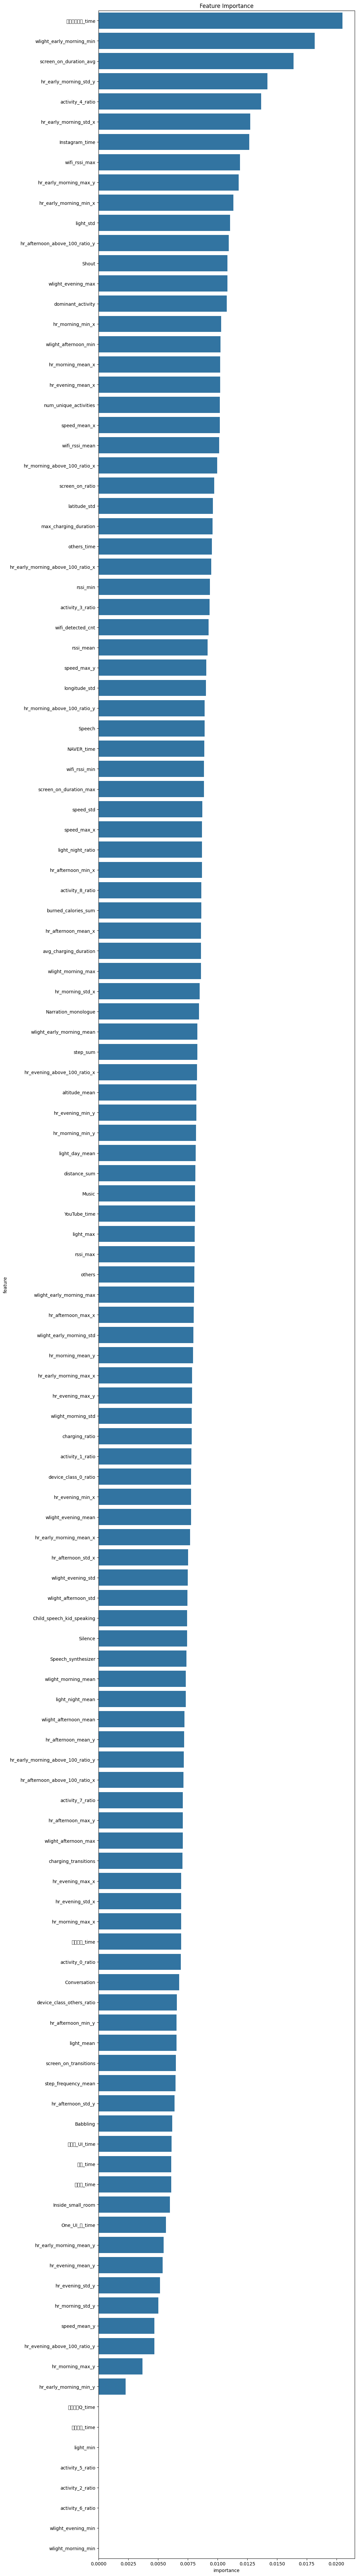

In [59]:
# importance 출력
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model_s1.feature_importances_
}).sort_values('importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 100))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [60]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred)  # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds[col].astype(int)  # 확률 아닌 class 예측

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv("submission_final.csv", index=False)

from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>